# Prototype 02 > Experiment 01

In [3]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [3]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [4]:
# Global Dependencies
from src.custom_types import Behavior
from src.data_provider import DataProvider
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#from prototypes.prototype_02.agent import Agent
#from prototypes.prototype_02.client import Client
from prototypes.prototype_02.enums import Execution, Evaluation
#from prototypes.prototype_02.server import Server
#from prototypes.prototype_02.experiment import Experiment

In [6]:
from enum import Enum

'''
class Behavior(Enum):
    NORMAL = "normal"
    ROOTKIT_BDVL = "bdvl"
    ROOTKIT_BEURK = "beurk"
    CNC_BACKDOOR_JAKORITAR = "backdoor_jakoritar"
    CNC_THETICK = "the_tick"
    CNC_OPT1 = "data_leak_1"
    CNC_OPT2 = "data_leak_2"
    RANSOMWARE_POC = "ransomware_poc"
'''

'''
class MTDTechnique(Enum):
    CONTINUE = "continue"
    CNC_IP_SHUFFLE = "cnc_ip_shuffle"
    ROOTKIT_SANITIZER = "rootkit_sanitizer"
    RANSOMWARE_DIRECTORY_TRAP = "ransomware_directory_trap"
    RANSOMWARE_FILE_EXTENSION_HIDE = "ransomware_file_extension_hide"
'''


class MTDTechnique(Enum):
    CNC_IP_SHUFFLE = "cnc_ip_shuffle"
    ROOTKIT_SANITIZER = "rootkit_sanitizer"
    RANSOMWARE_DIRTRAP = "ransomware_directory_trap"
    RANSOMWARE_FILE_EXT_HIDE = "ransomware_file_extension_hide"
    
actions = [
    MTDTechnique.CNC_IP_SHUFFLE,
    MTDTechnique.ROOTKIT_SANITIZER,
    MTDTechnique.RANSOMWARE_DIRTRAP,
    MTDTechnique.RANSOMWARE_FILE_EXT_HIDE
]

#mitigated_by = {
#    0: [Behavior.NORMAL],
#    1: [Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_THETICK, Behavior.CNC_OPT1, Behavior.CNC_OPT2, Behavior.NORMAL],
#    2: [Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK, Behavior.NORMAL],
#    3: [Behavior.RANSOMWARE_POC, Behavior.NORMAL],
#    4: [Behavior.RANSOMWARE_POC, Behavior.NORMAL],
#}

mitigated_by = {
    0: [Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_THETICK, Behavior.CNC_OPT1, Behavior.CNC_OPT2],
    1: [Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK],
    2: [Behavior.RANSOMWARE_POC],
    3: [Behavior.RANSOMWARE_POC],
}

In [7]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return strides

In [8]:
import numpy as np

def get_test_dataset(test_data):
    test_data_dict = {}

    for behavior, behavior_data in test_data.items():
        if behavior == Behavior.NORMAL:
            behavior_data = behavior_data[:2800]
            #continue
        else:
            behavior_data = behavior_data[:400]

        test_data_dict[behavior] = behavior_data

    return test_data_dict

In [9]:
import numpy as np

def multiclass_imbalance_degree(M):
    N = np.sum(M)
    n_cs = np.sum(M, axis=0)

    C = len(n_cs)
    MID = 0
    for n_c in n_cs:
        relative_label_frequency =  n_c / N
        MID+=relative_label_frequency*np.emath.logn(C, C*relative_label_frequency)   
    return round(MID, 4)

In [10]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def mean_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_two_norm = norm(L, 2)
    n = lis.shape[0]

    mean_cosine_similarity = 0
    for li in lis:
        mean_cosine_similarity += (1 / n) * (np.dot(L,li) / (L_two_norm * norm(li, 2)))

    return mean_cosine_similarity

In [11]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def weighted_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_one_norm = norm(L, 1)
    L_two_norm = norm(L, 2)
    #n = lis.shape[0]

    cosine_similarity = 0
    for li in lis:
        li_one_norm = norm(li, 1)
        li_two_norm = norm(li, 2)
        cosine_similarity +=  (li_one_norm/li_two_norm) * np.dot(L,li) 

    weighted_cosine_similarity = 1/(L_one_norm * L_two_norm)*cosine_similarity
    return round(weighted_cosine_similarity, 4)

In [12]:
def calculate_balance_metrics(sampling_probability_1, sampling_probabiliy_2, N):
    NR_SAMPLES_1 = np.array(list(sampling_probability_1.values()))*N
    NR_SAMPLES_2 = np.array(list(sampling_probabiliy_2.values()))*N

    sample_matrix = np.vstack([NR_SAMPLES_1, NR_SAMPLES_2])

    print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
    print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

In [24]:
import os
import sys
import torch
import numpy as np
from src.data_provider import DataProvider
from tabulate import tabulate

def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)
    return X_train, X_valid
    
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=3, scaling_minmax=True,
                                                                         scale_normal_only=True, filter_outliers=True)
normal_data = training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.6)

training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

evaluation_data = {}
for behavior, behavior_data in training_data.items():
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

getting Behavior.NORMAL
getting Behavior.RANSOMWARE_POC
getting Behavior.ROOTKIT_BDVL
getting Behavior.ROOTKIT_BEURK
getting Behavior.CNC_THETICK
getting Behavior.CNC_BACKDOOR_JAKORITAR
getting Behavior.CNC_OPT1
getting Behavior.CNC_OPT2
type(rdf): <class 'pandas.core.frame.DataFrame'>
rdf.columns: Index(['cpuUser', 'cpuSystem', 'cpuIdle', 'cpuIowait', 'cpuSoftIrq', 'tasks',
       'tasksRunning', 'tasksSleeping', 'tasksZombie', 'ramFree', 'ramUsed',
       'ramCache', 'memAvail', 'iface0RX', 'iface0TX', 'iface1RX', 'iface1TX',
       'numEncrypted', 'block:block_bio_backmerge', 'block:block_bio_remap',
       'block:block_dirty_buffer', 'block:block_getrq',
       'block:block_touch_buffer', 'block:block_unplug', 'clk:clk_set_rate',
       'cpu-migrations', 'cs', 'fib:fib_table_lookup',
       'filemap:mm_filemap_add_to_page_cache', 'gpio:gpio_value',
       'ipi:ipi_raise', 'irq:irq_handler_entry', 'irq:softirq_entry',
       'jbd2:jbd2_handle_start', 'jbd2:jbd2_start_commit', 'kmem:

In [25]:
from prototypes.prototype_02.autoencoder import AutoEncoder
from prototypes.prototype_02.autoencoder_utils import RMSELoss, initial_autoencoder_architecture

In [26]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(N_FEATURES), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=False)

In [28]:
autoencoder.evaluate(n_std=20, tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &   

In [20]:
autoencoder.evaluate(n_std=0, tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 99.92\%    & \notCalculated & \notCalculated & \notCalculated &        2530 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 3.00\%     & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &   

In [ ]:
experiment_id = 1
experiment_version = 1
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
#NR_ROUNDS = 180
NR_ROUNDS = 180
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 64
N_HIDDEN_2 = 64
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.9 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/4,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/16,
    Behavior.CNC_THETICK: 1/16, 
    Behavior.CNC_OPT1: 1/16,
    Behavior.CNC_OPT2: 1/16,
    Behavior.RANSOMWARE_POC: 1/4
}
'''
defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}
'''

SAMPLING_PROBABILITIES = defense_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, autoencoder, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, rl_training_data, state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

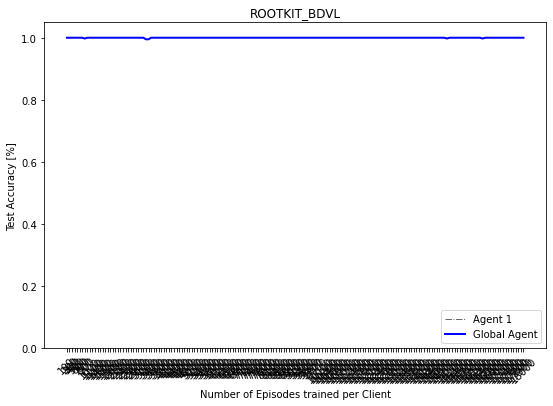

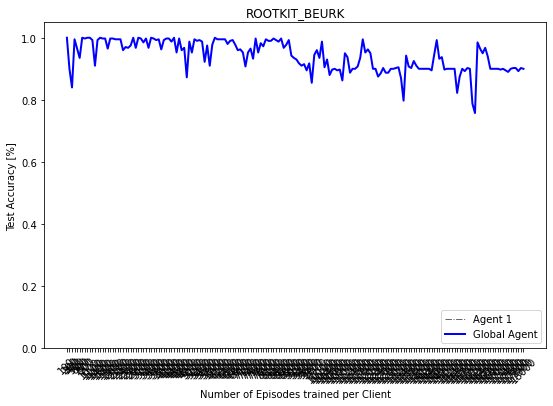

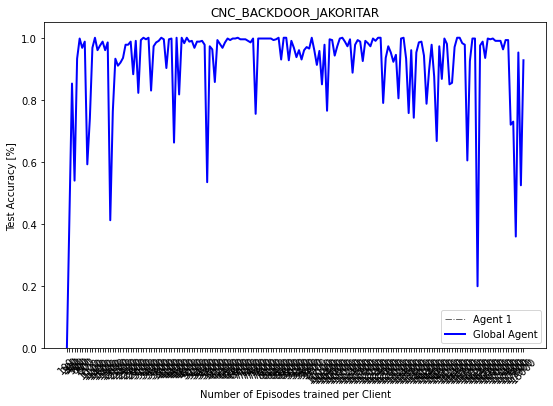

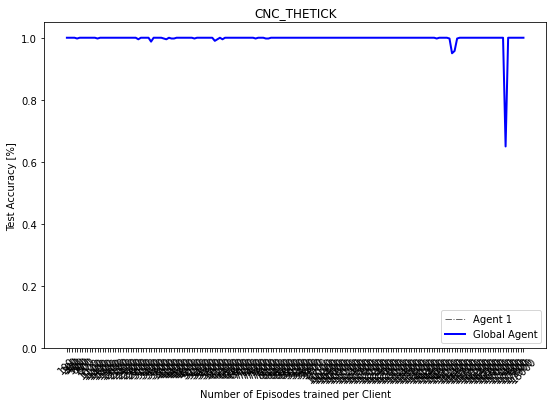

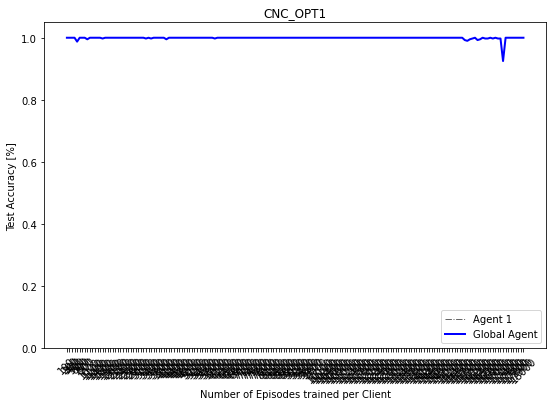

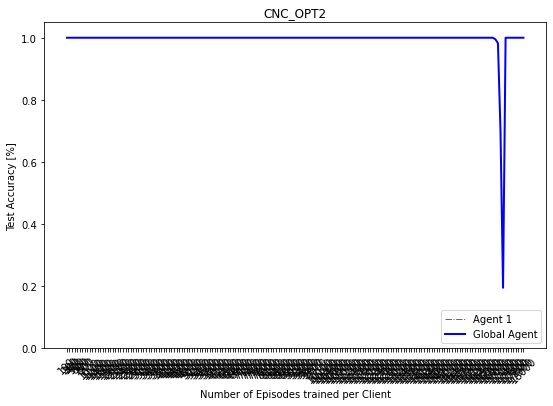

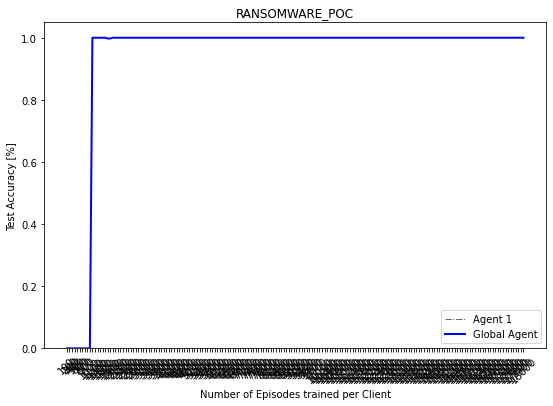

In [92]:
e1v1.plot_behavior_performances(show_episodes=True)

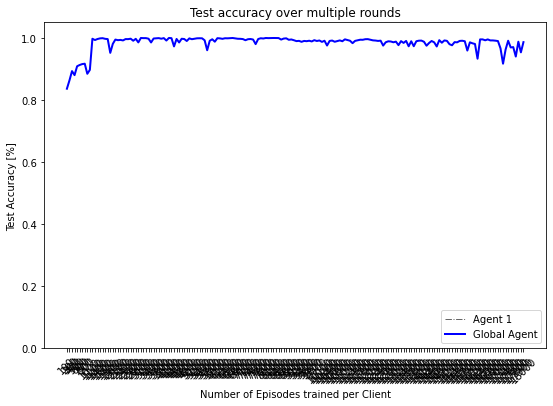

In [93]:
e1v1.plot_test_performances(show_episodes=True)

In [ ]:
experiment_id = 1
experiment_version = 2
e1v2 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v2.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
#NR_ROUNDS = 180
NR_ROUNDS = 18
NR_EPISODES_PER_ROUND = 1000
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 64
N_HIDDEN_2 = 64
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.9 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/4,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/16,
    Behavior.CNC_THETICK: 1/16, 
    Behavior.CNC_OPT1: 1/16,
    Behavior.CNC_OPT2: 1/16,
    Behavior.RANSOMWARE_POC: 1/4
}
'''
defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}
'''

SAMPLING_PROBABILITIES = defense_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, autoencoder, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, rl_training_data, state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v2.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

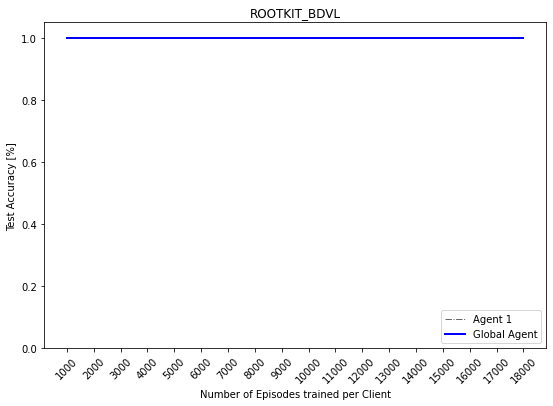

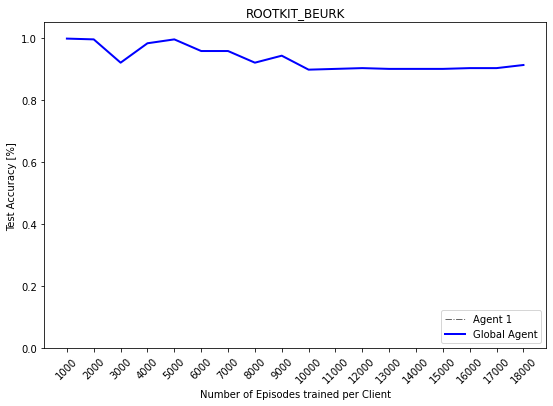

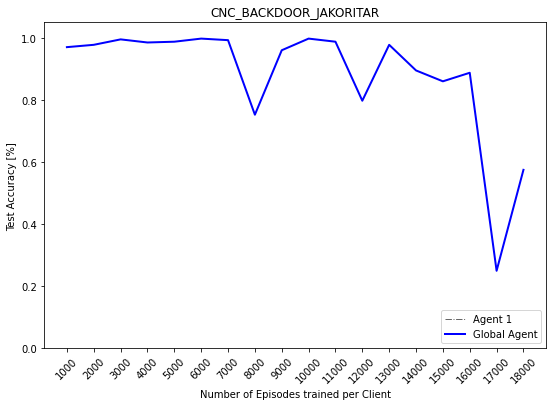

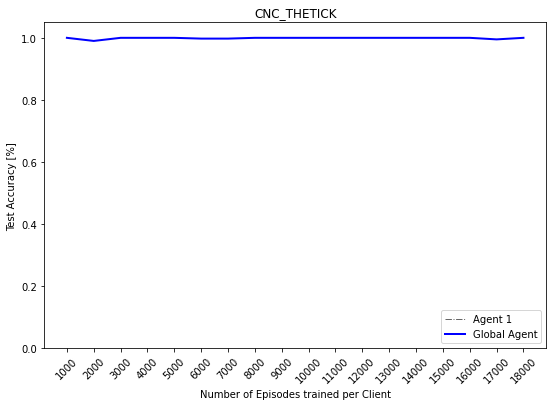

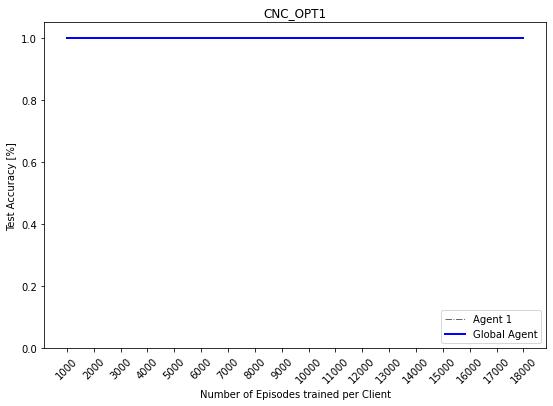

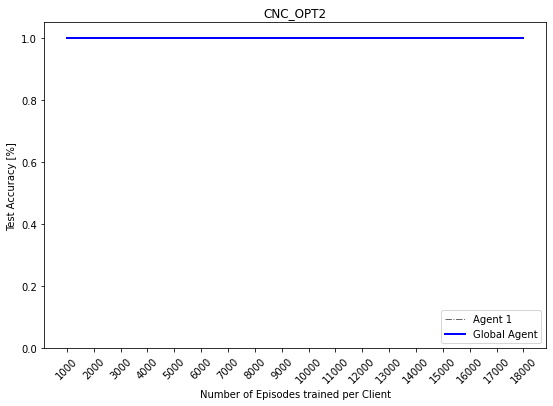

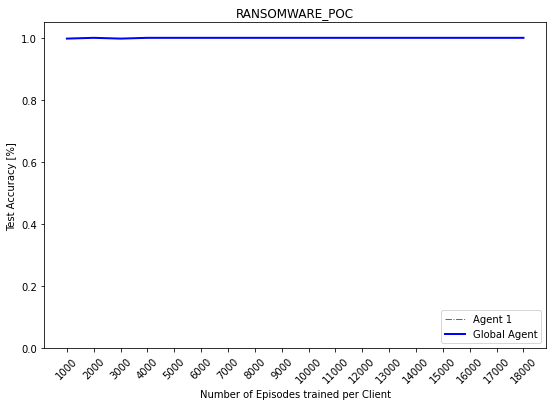

In [83]:
e1v2.plot_behavior_performances(show_episodes=True)

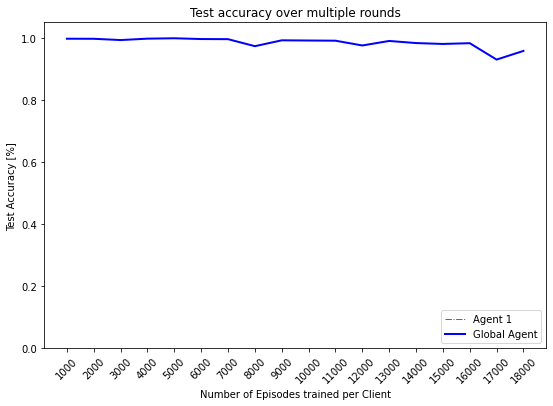

In [84]:
e1v2.plot_test_performances(show_episodes=True)

In [86]:
server.show_misclassification_rates()

Client 1
0 FNs / 29965 Steps ... 0.0
0 FPs /29965 Steps ... 0.0
---


In [67]:
experiment_id = 1
experiment_version = 0
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
NR_ROUNDS = 20
NR_EPISODES_PER_ROUND = 1000
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 128
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities


calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

6.25e-05
MID: 0.0
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=5, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.0
Training each of the 1 clients for a total of 20000 episodes distributed over 20 rounds with 1000 episodes per round.
>>> SERVER TRAINING ROUND 1/20 <<<



KeyboardInterrupt



0.0006944444444444445
MID: 0.0833
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=16, bias=True)
  (L4): Linear(in_features=64, out_features=4, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.3
Training each of the 10 clients for a total of 1800 episodes distributed over 18 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/18 <<<
Evaluating round 1/18
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2068 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |           400 |
| Behavior.ROOTKIT_BDVL       

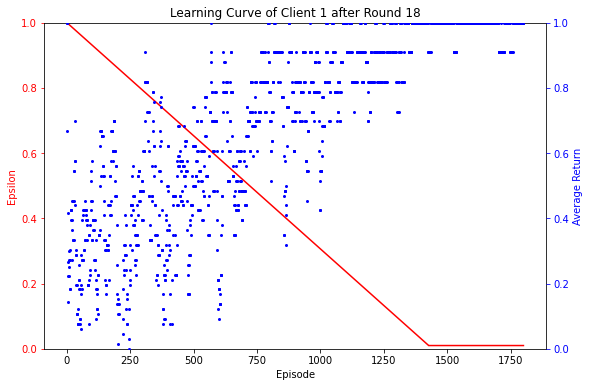

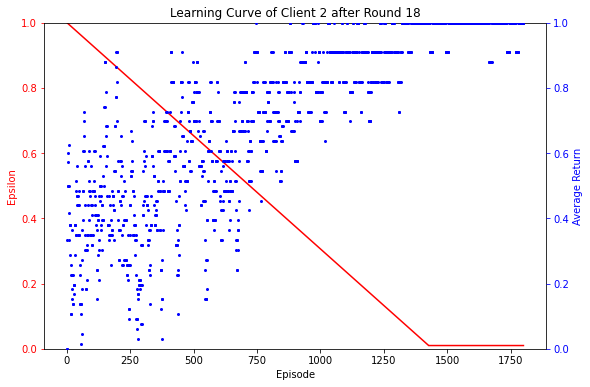

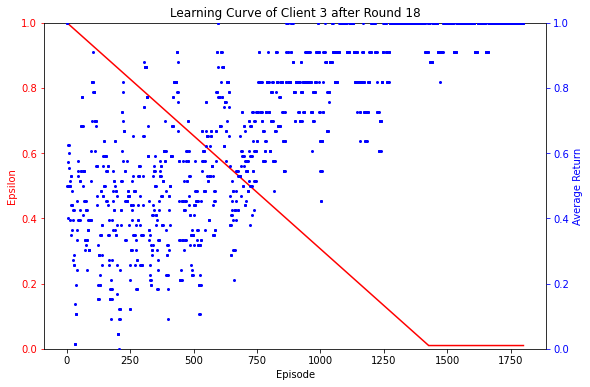

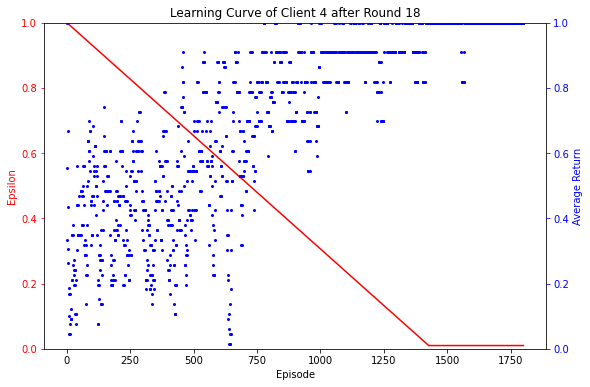

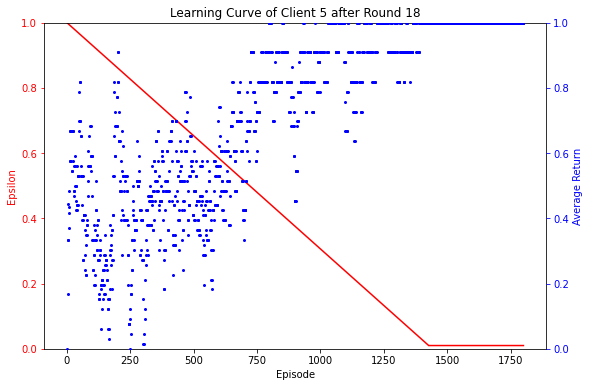

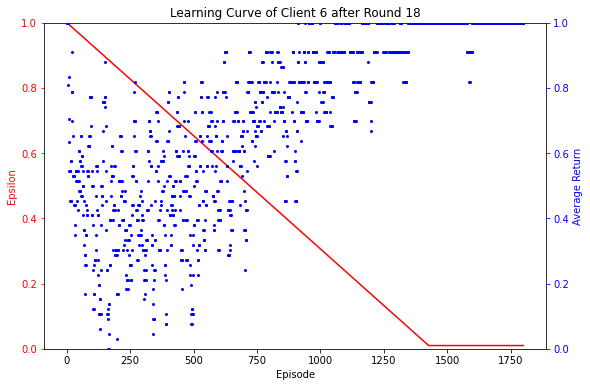

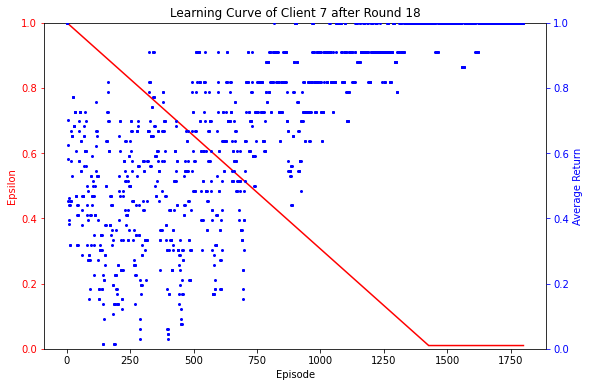

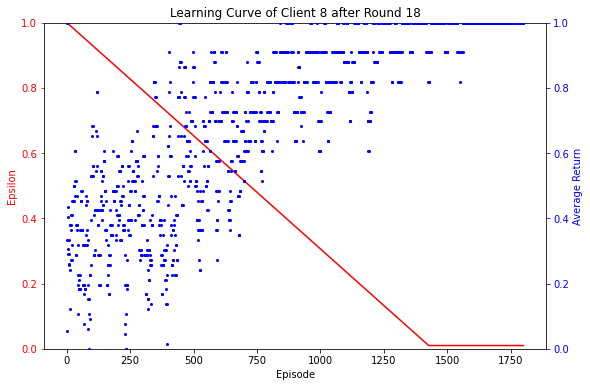

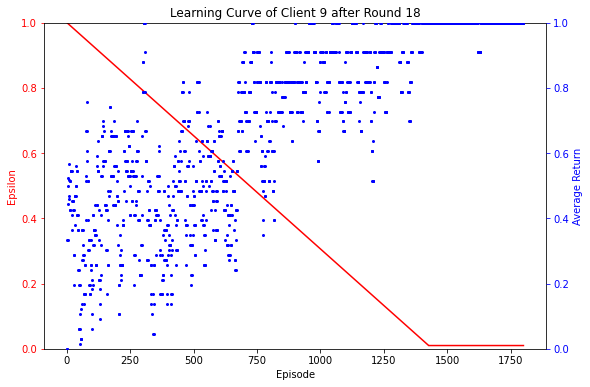

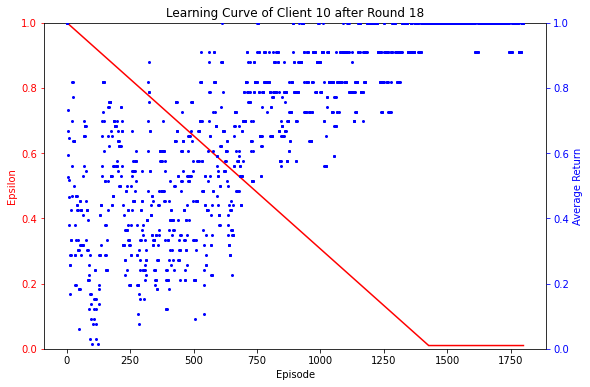

In [94]:
experiment_id = 1
experiment_version = 3
e1v3 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v3.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 10
#NR_ROUNDS = 180
NR_ROUNDS = 18
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 64
N_HIDDEN_2 = 64
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.9 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/4,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/16,
    Behavior.CNC_THETICK: 1/16, 
    Behavior.CNC_OPT1: 1/16,
    Behavior.CNC_OPT2: 1/16,
    Behavior.RANSOMWARE_POC: 1/4
}
'''
defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}
'''

SAMPLING_PROBABILITIES = defense_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, autoencoder, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, rl_training_data, state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v3.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

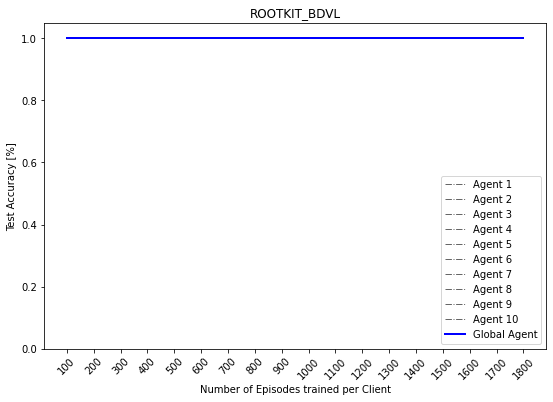

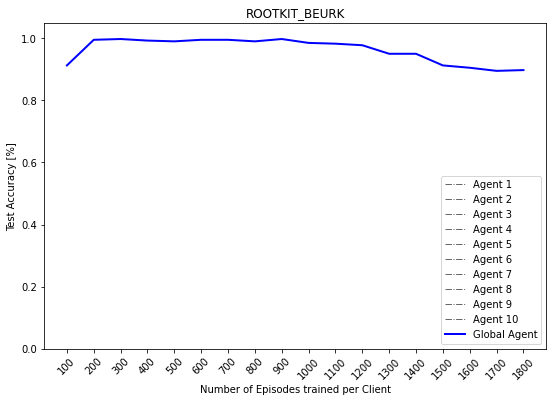

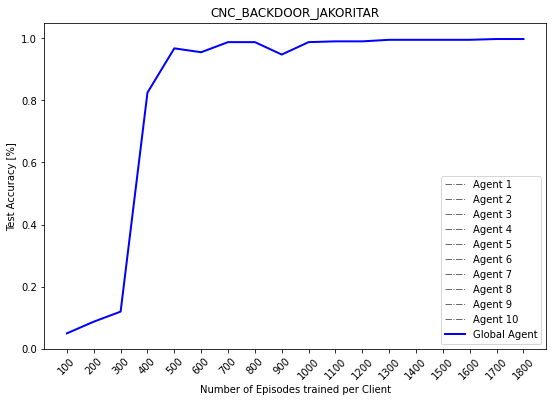

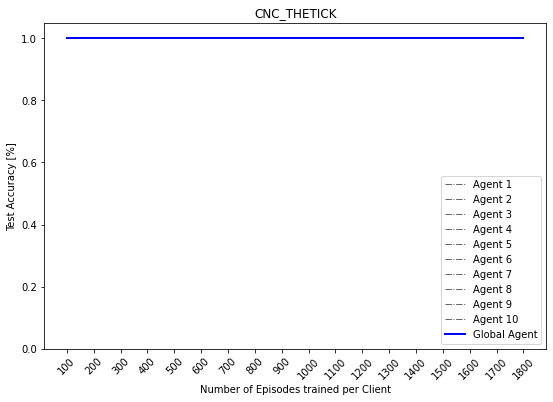

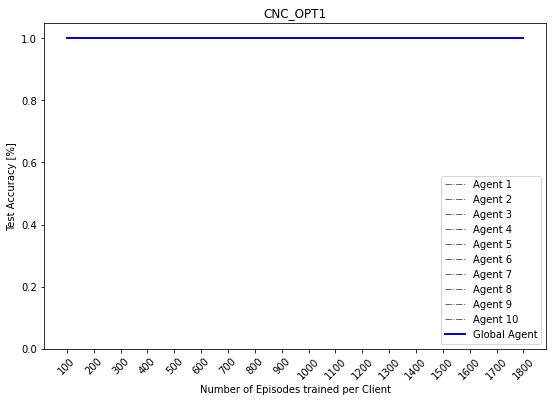

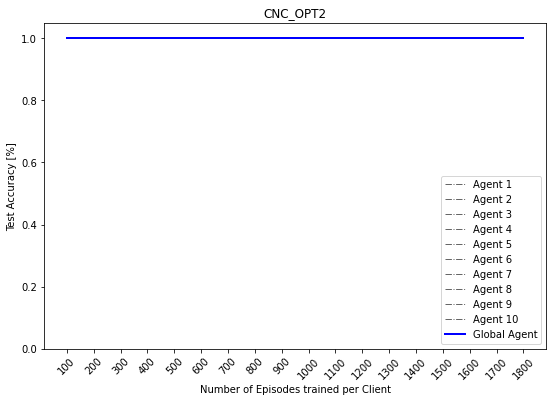

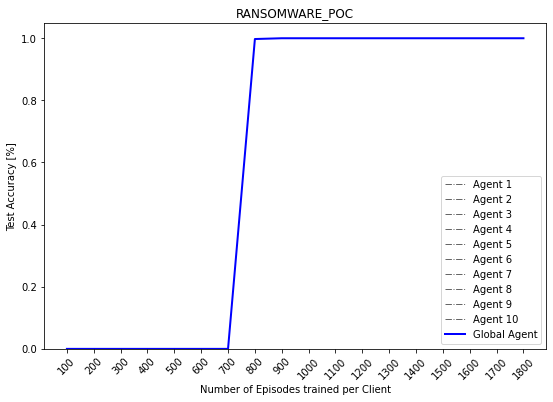

In [96]:
e1v3.plot_behavior_performances(show_episodes=True)

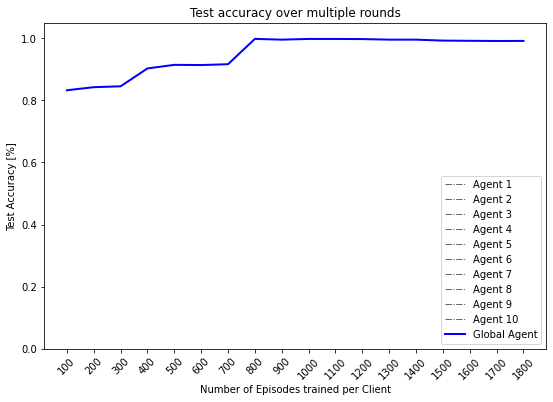

In [97]:
e1v3.plot_test_performances()

## Ex.1 / V.0

In [ ]:
for agent in agents:
    plt.plot(list(range(len(agent.losses))), agent.losses)
    plt.show()

In [100]:
server.show_misclassification_rates()

Client 1
2 FNs / 1972 Steps ... 0.001
1778 FPs /1972 Steps ... 0.9016
---
Client 2
61 FNs / 958 Steps ... 0.0637
68 FPs /958 Steps ... 0.071
---
Client 3
67 FNs / 970 Steps ... 0.0691
6 FPs /970 Steps ... 0.0062
---
Client 4
25 FNs / 951 Steps ... 0.0263
15 FPs /951 Steps ... 0.0158
---
Client 5
25 FNs / 941 Steps ... 0.0266
17 FPs /941 Steps ... 0.0181
---
Client 6
21 FNs / 904 Steps ... 0.0232
4 FPs /904 Steps ... 0.0044
---
Client 7
54 FNs / 895 Steps ... 0.0603
3 FPs /895 Steps ... 0.0034
---
Client 8
20 FNs / 956 Steps ... 0.0209
2 FPs /956 Steps ... 0.0021
---
Client 9
27 FNs / 932 Steps ... 0.029
0 FPs /932 Steps ... 0.0
---
Client 10
11 FNs / 893 Steps ... 0.0123
3 FPs /893 Steps ... 0.0034
---


## Experiment 01 > Version 01

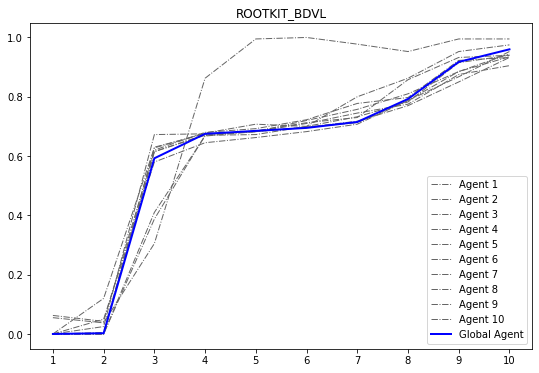

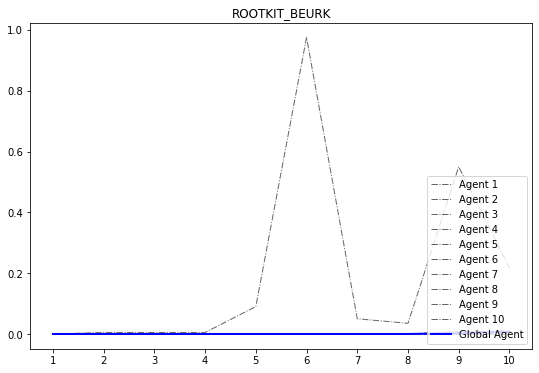

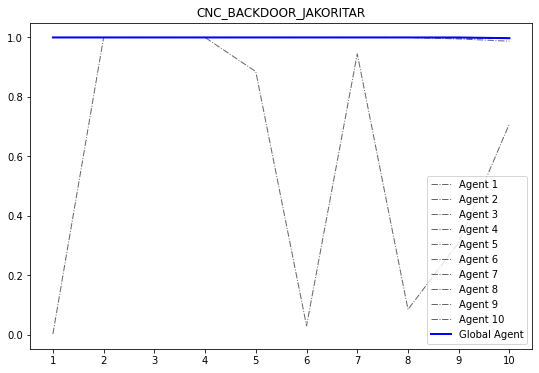

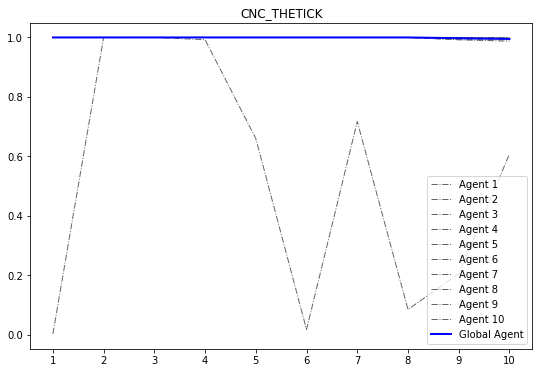

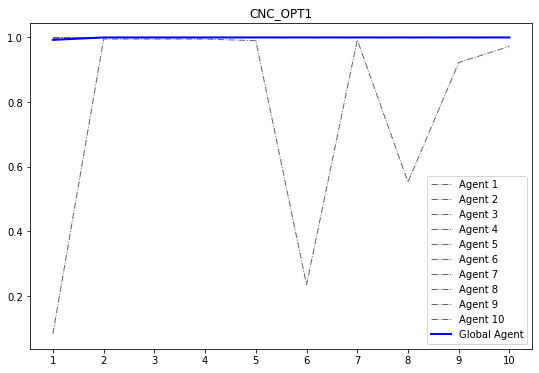

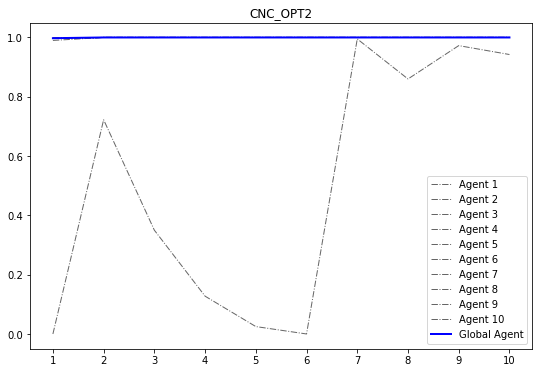

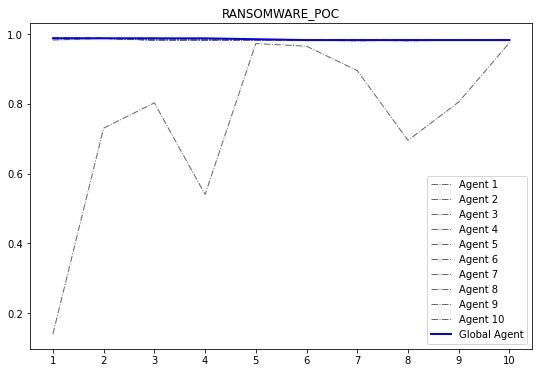

In [82]:
e1v1.plot_behavior_performances()

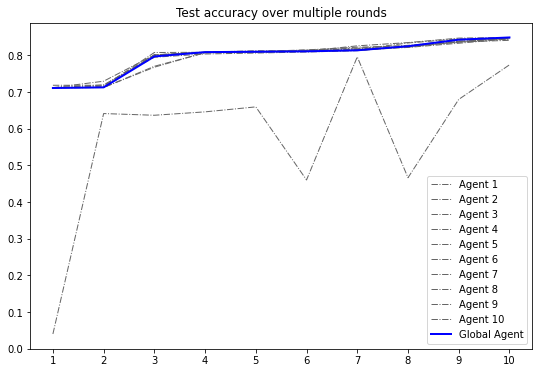

In [83]:
e1v1.plot_test_performances()

In [90]:
def plot_test_performances(server):
    agents = list(map(lambda client: client.agent, server.clients))
    agents.append(server.global_agent)

    plt.figure(figsize=(9,6))
    for agent in agents:
        #print(agent.get_name())
        #print(agent.total_accuracies)
        #print(agent.mean_class_accuracies)
        #print("---------")
        #plt.ylim(0, 0.9)
        agent_id = agent.agent_id

        label = agent.get_name()
        x = list(agent.total_accuracies.keys())
        y = agent.total_accuracies.values()

        if agent_id == 0:
            color='blue'
            linestyle='solid'
            linewidth=2
        else:
            color='#666666'
            linestyle='dashdot'
            linewidth=1
            #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

        #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    #plt.title('Test Accuracy over multiple Training Rounds')
    print(f"Test Accuracy over multiple Training Rounds")
    plt.xlabel('Training Round')
    plt.ylabel('Test Accuracy')
    plt.xticks(x)
    #plt.ylim(top=1)
    plt.legend(loc="lower right")
    plt.show()

def plot_behavior_performances(server):
    agents = list(map(lambda client: client.agent, server.clients))
    agents.append(server.global_agent)

    non_normal_behaviors = [behavior for behavior in Behavior if behavior is not Behavior.NORMAL]
    for behavior in non_normal_behaviors:
        plt.figure(figsize=(9,6))
        for agent in agents:
            #print(agent.get_name())
            #print(agent.total_accuracies)
            #print(agent.mean_class_accuracies)
            #print("---------")
            agent_id = agent.agent_id

            label = agent.get_name()
            x = list(agent.behavior_accuracies[behavior].keys())
            #print(x)
            y = agent.behavior_accuracies[behavior].values()
            #print(y)

            if agent_id == 0:
                color='blue'
                linestyle='solid'
                linewidth=2
            else:
                color='#666666'
                linestyle='dashdot'
                linewidth=1
                #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
            plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

            #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        plt.xticks(x)
        print(f"Mitigation Performance for {behavior.name}")
        #plt.title(f"Mitigation Performance for {behavior.name}")
        plt.xlabel('Training Round')
        plt.ylabel('Test Accuracy')
        plt.ylim(0, 1.05)
        #plt.ylim(top=1)
        #plt.title(behavior.name)
        plt.legend(loc="lower right")
        plt.show()

Test Accuracy over multiple Training Rounds


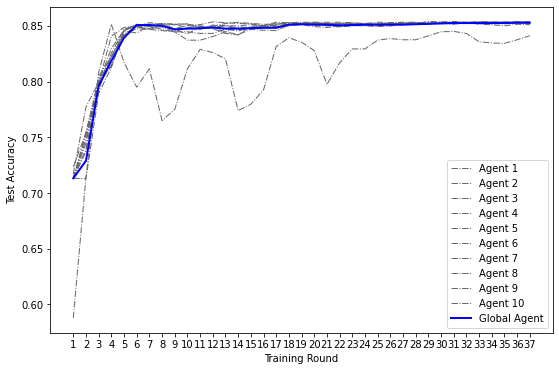

In [91]:
plot_test_performances(server)

Mitigation Performance for ROOTKIT_BDVL


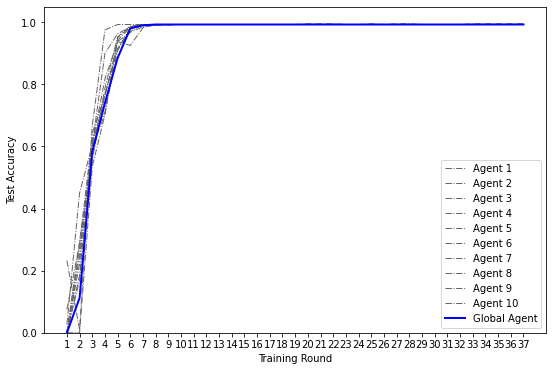

Mitigation Performance for ROOTKIT_BEURK


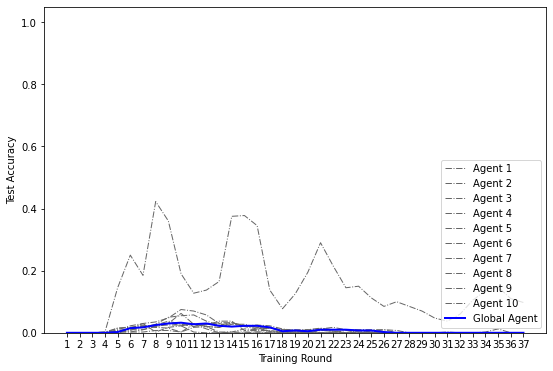

Mitigation Performance for CNC_BACKDOOR_JAKORITAR


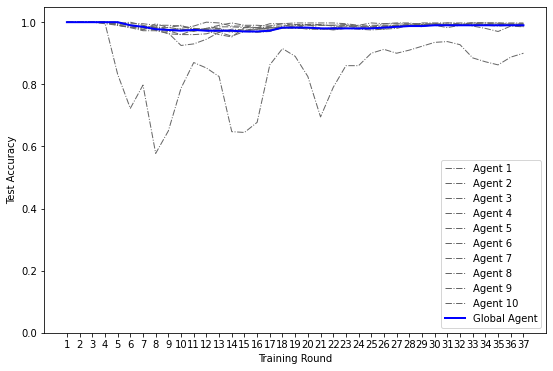

Mitigation Performance for CNC_THETICK


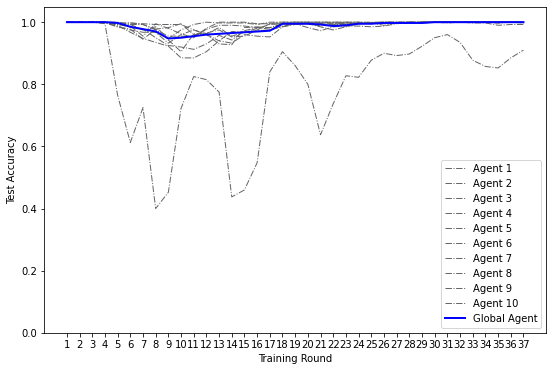

Mitigation Performance for CNC_OPT1


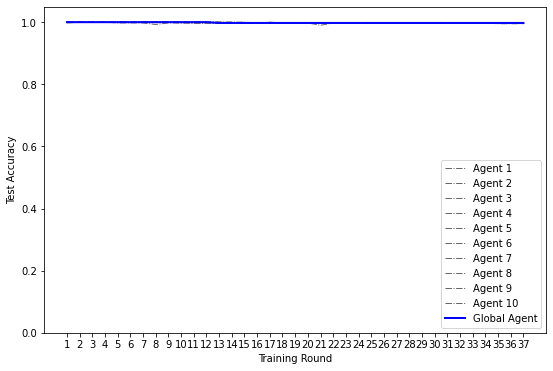

Mitigation Performance for CNC_OPT2


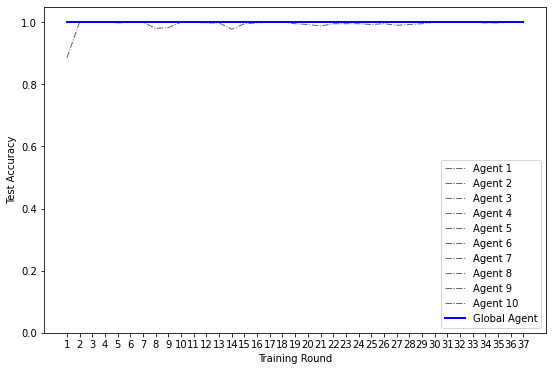

Mitigation Performance for RANSOMWARE_POC


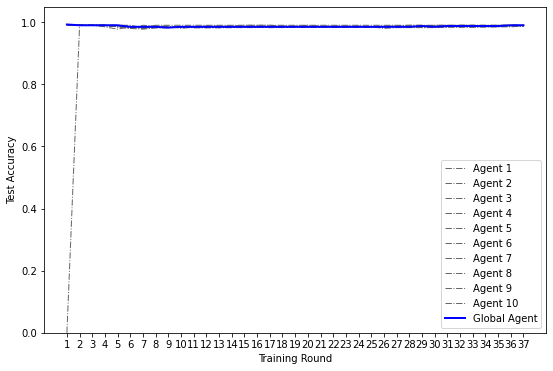

In [92]:
plot_behavior_performances(server)